In [366]:
import os


def get_gesture_list() -> list[str]:
    folder_path = "./savedata"
    if not os.path.exists(folder_path) or not os.listdir(folder_path):
        return []
    else:
        return [
            name
            for name in os.listdir(folder_path)
            if os.path.isdir(os.path.join(folder_path, name))
        ]

def get_gesture_files(gesture: str) -> list[str]:
    folder_path = f"./savedata/{gesture}"
    if not os.path.exists(folder_path) or not os.listdir(folder_path):
        return []
    else:
        return [
            name
            for name in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, name))
        ]

In [367]:
from typing import List

import pandas as pd


# Load data
data: dict[str, List[pd.DataFrame]] = {}
gestures = get_gesture_list()
for gesture in gestures:
    data[gesture] = []  # Initialize the list for each gesture
    gesture_files = get_gesture_files(gesture)
    for index, gesture_file in enumerate(gesture_files):
        # print(f"{gesture = }, {index = }")
        df = pd.read_csv(f"./savedata/{gesture}/{gesture_file}")

        # Drop column 'Time' if found
        df = df.drop('Time', axis=1, errors='ignore')

        data[gesture].append(df)

In [368]:
# Explore the data
data1 = data[gestures[0]][0]
data1.head()

,gX,gY,gZ
0,-0.14,-0.28,-0.14
1,-0.14,-0.35,-0.14
2,-0.28,-0.35,-0.07
3,-0.28,-0.35,-0.07
4,-0.28,-0.35,-0.07


In [369]:
# Explore the data
data1.describe()

,gX,gY,gZ
count,120.000000,120.000000,120.000000
mean,-0.207667,-0.323750,-0.075833
std,0.080113,0.072065,0.034655
min,-0.420000,-0.490000,-0.140000
25%,-0.280000,-0.350000,-0.070000
50%,-0.210000,-0.350000,-0.070000
75%,-0.140000,-0.280000,-0.070000
max,0.000000,-0.140000,0.000000


C:\Users\KaiZen42\AppData\Local\Temp\ipykernel_7420\941310383.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


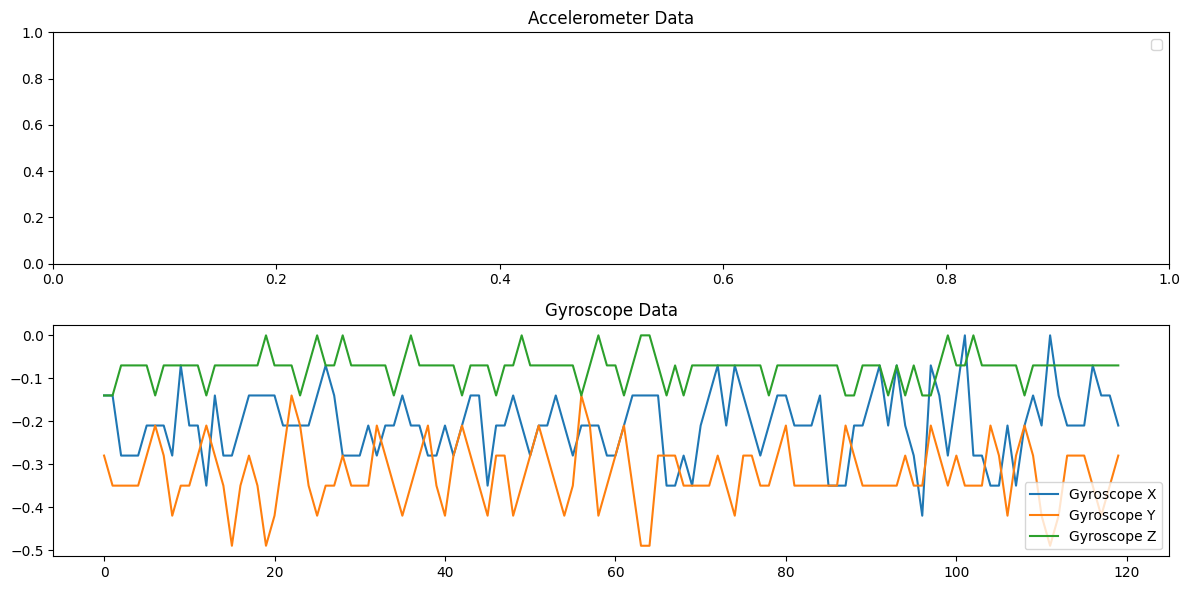

In [370]:
# Visualize the sensor data
from matplotlib import pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data1['aX'], label='Accelerometer X')
plt.plot(data1['aY'], label='Accelerometer Y')
plt.plot(data1['aZ'], label='Accelerometer Z')
plt.title('Accelerometer Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data1['gX'], label='Gyroscope X')
plt.plot(data1['gY'], label='Gyroscope Y')
plt.plot(data1['gZ'], label='Gyroscope Z')
plt.title('Gyroscope Data')
plt.legend()
plt.tight_layout()

plt.show()


In [371]:
# Import necessary libraries
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# Assuming your data is in the following format
# data: dict[str, List[pd.DataFrame]]
# The str field is the "gesture"
# The List[pd.DataFrame] is the data "points"

# Prepare the data
def prepare_data(data):
    X = []
    y = []
    gestures = list(data.keys())
    for gesture in gestures:
        for df in data[gesture]:
            X.append(df.values)
            y.append(gestures.index(gesture))
    X = np.array(X)
    y = to_categorical(y, num_classes=len(gestures))
    return X, y

# Load your data
# data = ... (Data already loaded)

# Prepare the data
X, y = prepare_data(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Flatten(input_shape=(120, 6)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(len(data.keys()), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/20


c:\Users\KaiZen42\Desktop\EIE3127 Lab4\UI\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.2580 - loss: 105.7205 - val_accuracy: 0.4444 - val_loss: 9.9581
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4761 - loss: 24.2211 - val_accuracy: 0.4722 - val_loss: 10.6343
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4991 - loss: 18.4426 - val_accuracy: 0.4722 - val_loss: 10.8958
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5202 - loss: 19.7118 - val_accuracy: 0.5000 - val_loss: 10.3448
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6295 - loss: 10.2604 - val_accuracy: 0.5278 - val_loss: 9.6892
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5965 - loss: 12.5440 - val_accuracy: 0.5833 - val_loss: 8.9509
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6175 - loss: 7.9583 - val_accuracy: 0.6389 - val_loss: 8.2030
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6678 - loss: 8.2024 - val_accuracy: 0.6667 - val_loss: 7.4677


In [372]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix: ")
print(cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Confusion Matrix: 
[[11  7  1]
 [ 0 13  0]
 [ 0  0  4]]
